StepLR
Every few epochs, multiply the learning rate by a factor less than 1

Modify the learning rate to start at 0.001, 
and then decrease it to 50% of its current value every 50 epochs.

trained on RTX_4090

training start!
Epoch [10/300], D Loss: 1.5621, G Loss: 1.9043


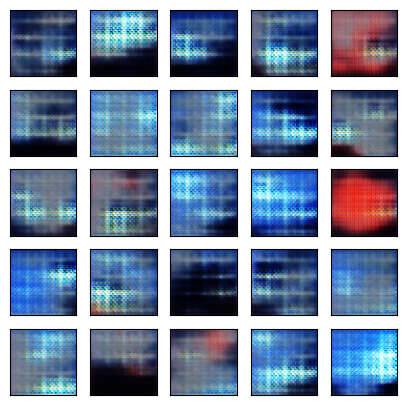

Epoch [20/300], D Loss: 1.4847, G Loss: 1.9805


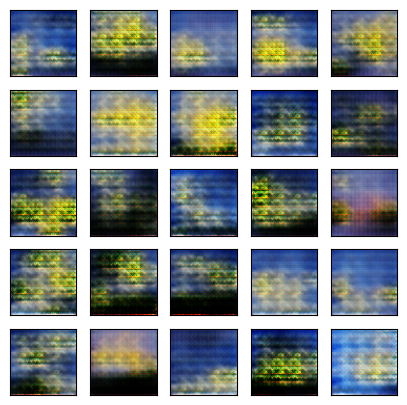

Epoch [30/300], D Loss: 1.2165, G Loss: 2.0203


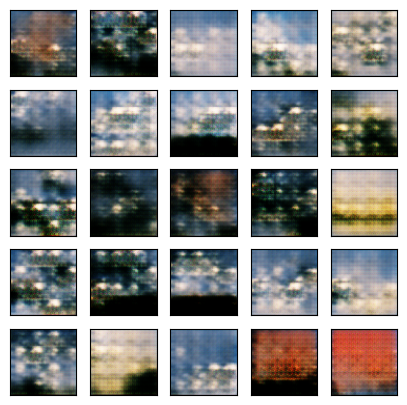

Epoch [40/300], D Loss: 1.2864, G Loss: 1.8708


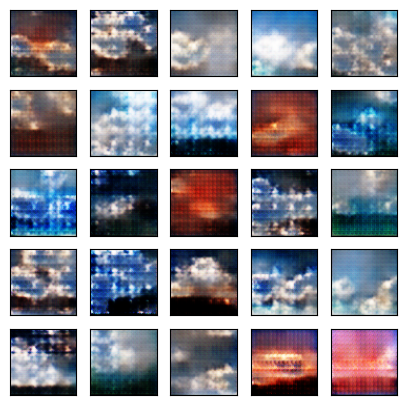

Epoch [50/300], D Loss: 1.1308, G Loss: 1.8915


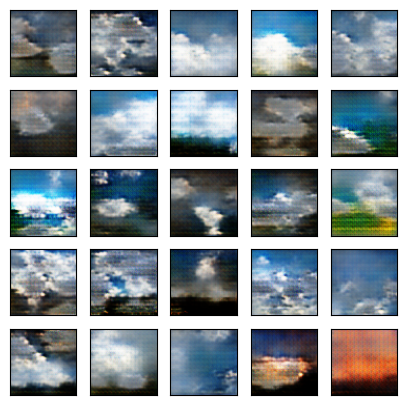

Epoch [60/300], D Loss: 0.7910, G Loss: 2.6289


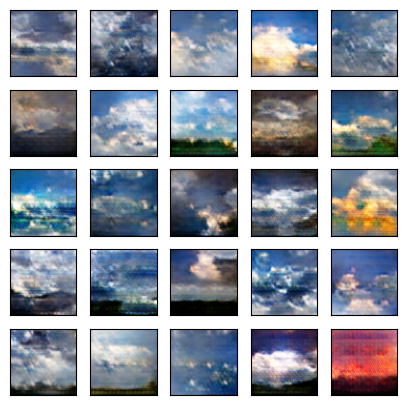

Epoch [70/300], D Loss: 0.7336, G Loss: 3.4361


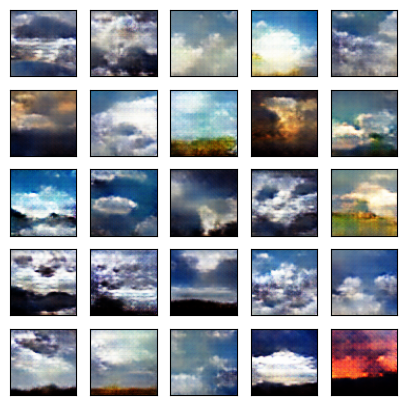

Epoch [80/300], D Loss: 0.6179, G Loss: 4.1759


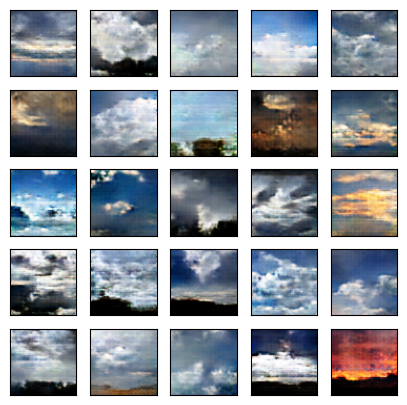

Epoch [90/300], D Loss: 0.3427, G Loss: 4.9316


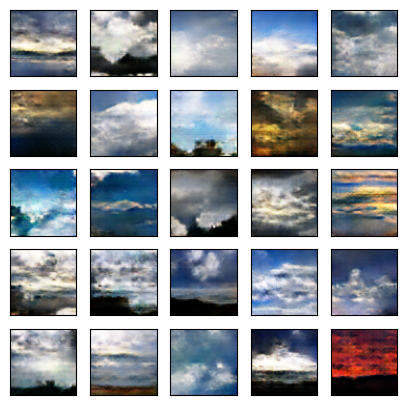

Epoch [100/300], D Loss: 0.3058, G Loss: 5.1309


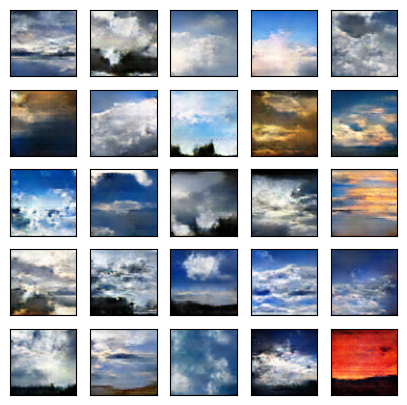

Epoch [110/300], D Loss: 0.1099, G Loss: 5.0328


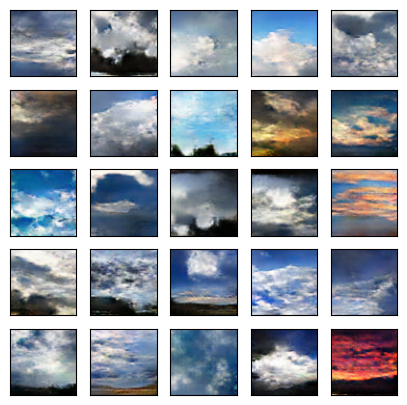

Epoch [120/300], D Loss: 0.0812, G Loss: 5.7643


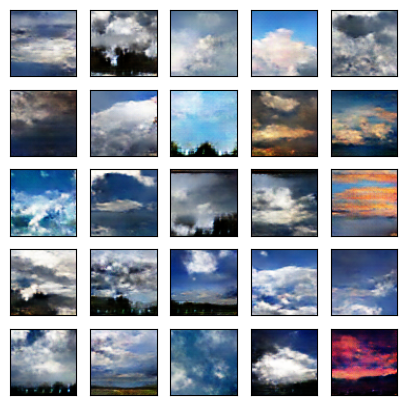

Epoch [130/300], D Loss: 0.0620, G Loss: 6.2549


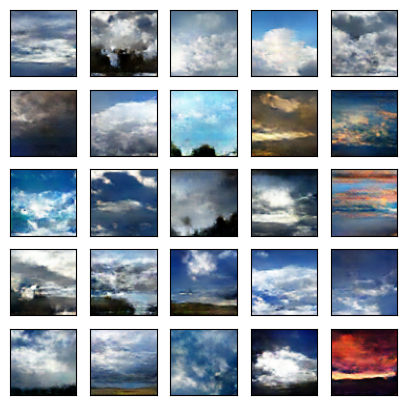

Epoch [140/300], D Loss: 0.1420, G Loss: 7.3746


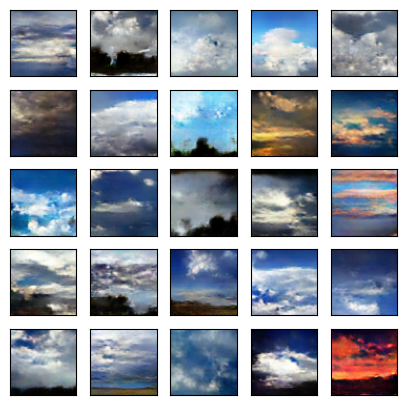

Epoch [150/300], D Loss: 0.0658, G Loss: 7.3426


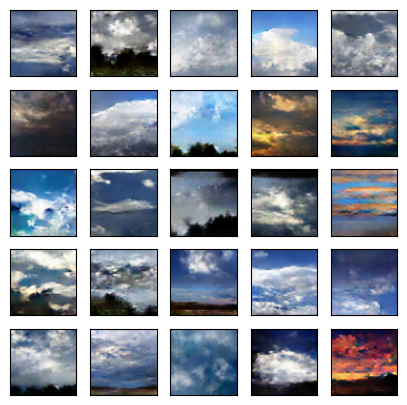

Epoch [160/300], D Loss: 0.0224, G Loss: 6.7064


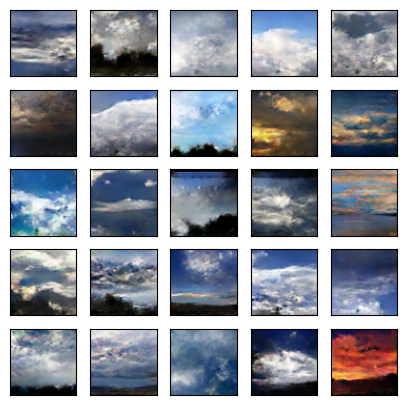

Epoch [170/300], D Loss: 0.0924, G Loss: 6.7642


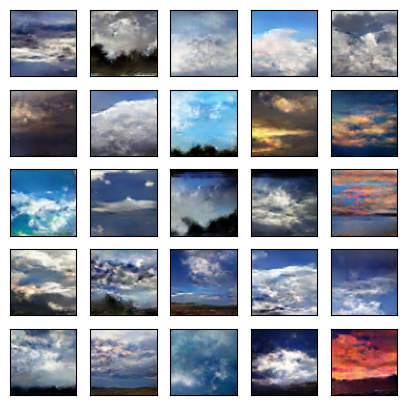

Epoch [180/300], D Loss: 0.0155, G Loss: 7.3513


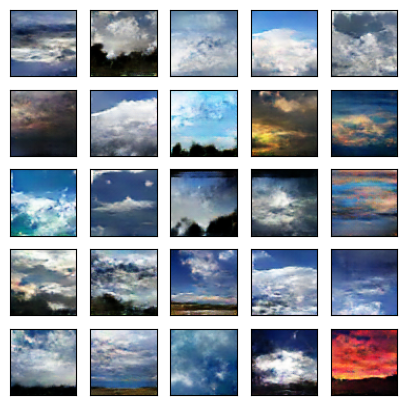

Epoch [190/300], D Loss: 0.0123, G Loss: 7.8707


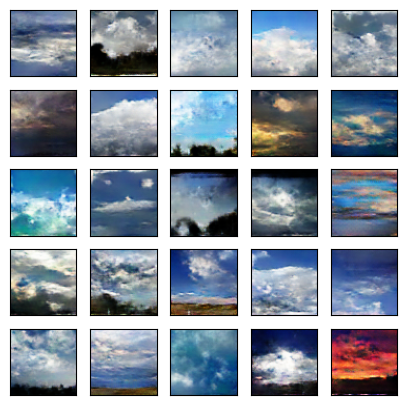

Epoch [200/300], D Loss: 0.0203, G Loss: 7.3251


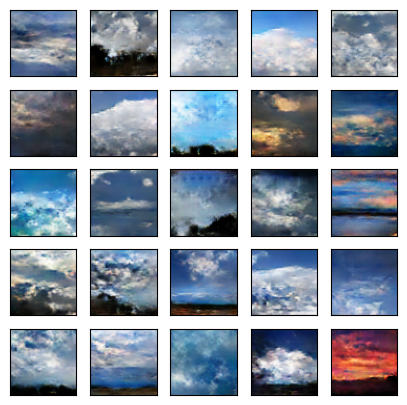

Epoch [210/300], D Loss: 0.0113, G Loss: 7.5341


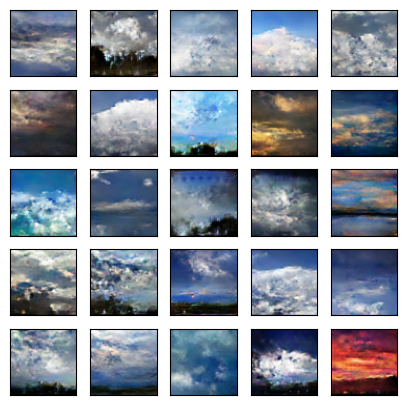

Epoch [220/300], D Loss: 0.0117, G Loss: 7.8141


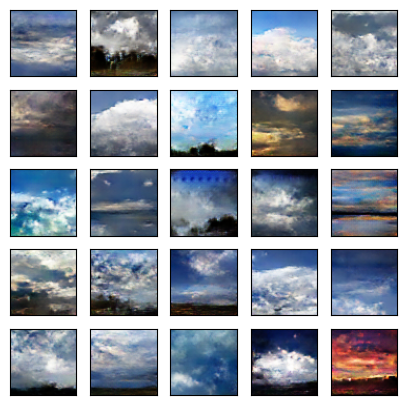

Epoch [230/300], D Loss: 0.0127, G Loss: 7.8980


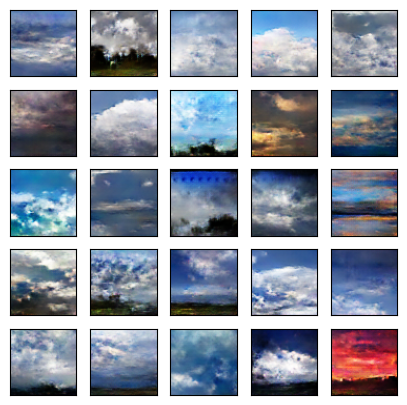

Epoch [240/300], D Loss: 0.0065, G Loss: 8.0197


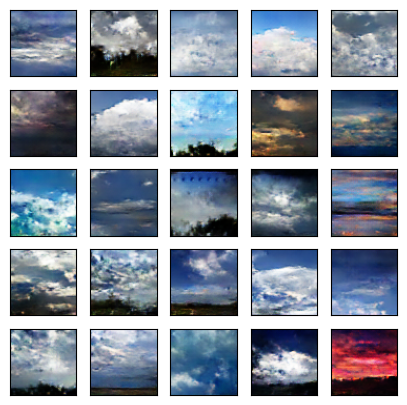

Epoch [250/300], D Loss: 0.0110, G Loss: 8.1487


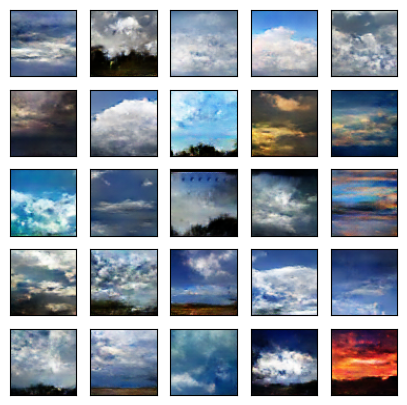

Epoch [260/300], D Loss: 0.0049, G Loss: 8.3737


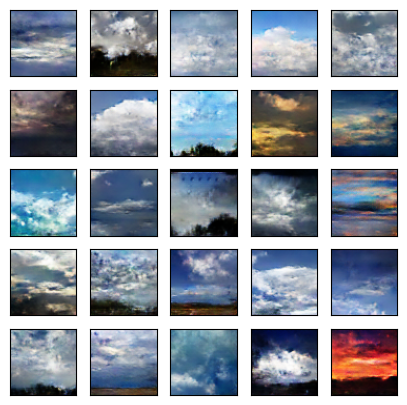

Epoch [270/300], D Loss: 0.0062, G Loss: 8.4937


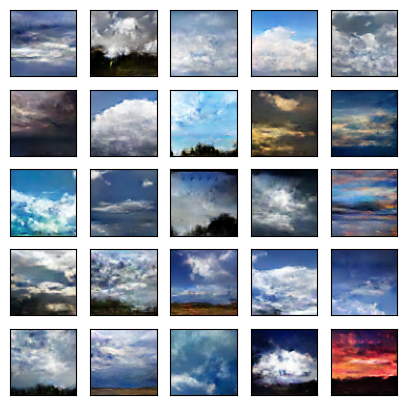

Epoch [280/300], D Loss: 0.0090, G Loss: 8.1939


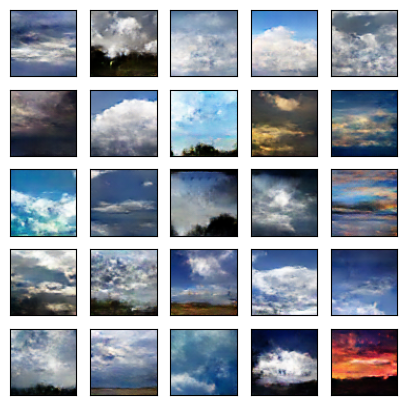

Epoch [290/300], D Loss: 0.0046, G Loss: 9.0154


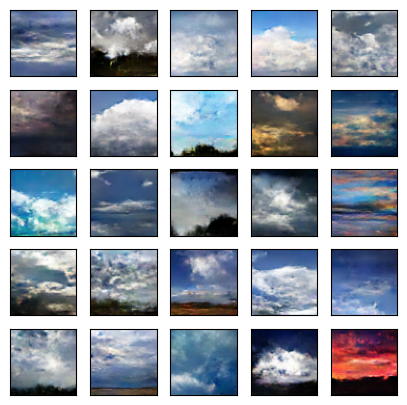

Epoch [300/300], D Loss: 0.0057, G Loss: 8.5752


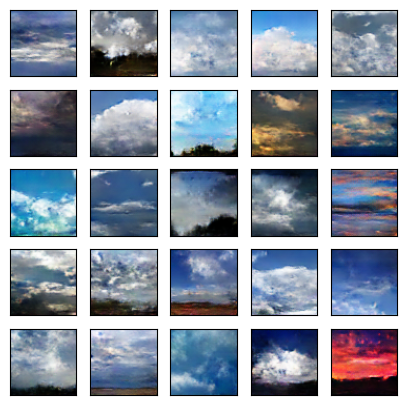

Total training time: 333.97s


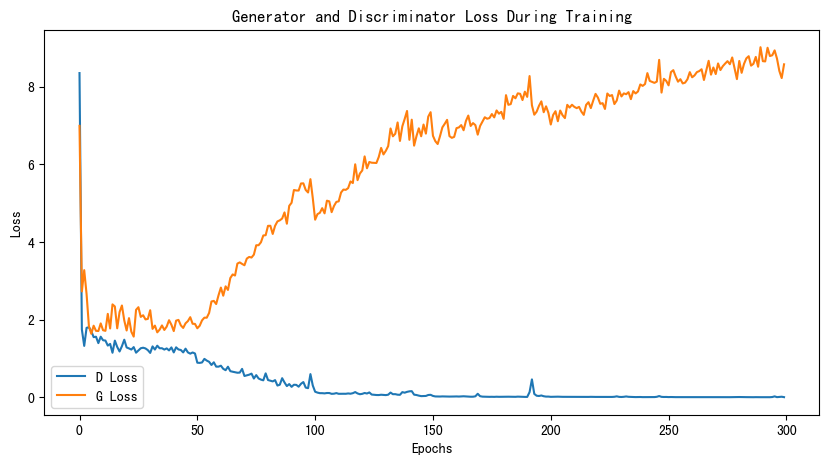

In [1]:
import os, time
import itertools
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
from PIL import Image
import matplotlib.pyplot as plt
from torch.optim import lr_scheduler


class CloudDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_files = [os.path.join(root_dir, f) for f in os.listdir(root_dir) if
                            f.endswith('.png') or f.endswith('.jpg')]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image


class generator(nn.Module):
    def __init__(self, d=128):
        super(generator, self).__init__()
        self.deconv1 = nn.ConvTranspose2d(100, d * 8, 4, 1, 0)
        self.deconv1_bn = nn.BatchNorm2d(d * 8)
        self.deconv2 = nn.ConvTranspose2d(d * 8, d * 4, 4, 2, 1)
        self.deconv2_bn = nn.BatchNorm2d(d * 4)
        self.deconv3 = nn.ConvTranspose2d(d * 4, d * 2, 4, 2, 1)
        self.deconv3_bn = nn.BatchNorm2d(d * 2)
        self.deconv4 = nn.ConvTranspose2d(d * 2, d, 4, 2, 1)
        self.deconv4_bn = nn.BatchNorm2d(d)
        self.deconv5 = nn.ConvTranspose2d(d, 3, 4, 2, 1)

    def weight_init(self, mean, std):
        for m in self.modules():
            if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d):
                nn.init.xavier_normal_(m.weight.data)
                m.bias.data.zero_()

    def forward(self, input):
        x = F.relu(self.deconv1_bn(self.deconv1(input)))
        x = F.relu(self.deconv2_bn(self.deconv2(x)))
        x = F.relu(self.deconv3_bn(self.deconv3(x)))
        x = F.relu(self.deconv4_bn(self.deconv4(x)))
        x = F.tanh(self.deconv5(x))
        return x


class discriminator(nn.Module):
    def __init__(self, d=128):
        super(discriminator, self).__init__()
        self.conv1 = nn.Conv2d(3, d, 4, 2, 1)
        self.conv2 = nn.Conv2d(d, d * 2, 4, 2, 1)
        self.conv2_bn = nn.BatchNorm2d(d * 2)
        self.conv3 = nn.Conv2d(d * 2, d * 4, 4, 2, 1)
        self.conv3_bn = nn.BatchNorm2d(d * 4)
        self.conv4 = nn.Conv2d(d * 4, d * 8, 4, 2, 1)
        self.conv4_bn = nn.BatchNorm2d(d * 8)
        self.conv5 = nn.Conv2d(d * 8, 1, 4, 1, 0)

    def weight_init(self, mean, std):
        for m in self.modules():
            if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d):
                nn.init.xavier_normal_(m.weight.data)
                m.bias.data.zero_()

    def forward(self, input):
        x = F.leaky_relu(self.conv1(input), 0.2)
        x = F.leaky_relu(self.conv2_bn(self.conv2(x)), 0.2)
        x = F.leaky_relu(self.conv3_bn(self.conv3(x)), 0.2)
        x = F.leaky_relu(self.conv4_bn(self.conv4(x)), 0.2)
        x = F.sigmoid(self.conv5(x))
        return x


batch_size = 32
lr = 0.001
train_epoch = 300


img_size = 64
transform = transforms.Compose([
    transforms.Resize(img_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])
root_dir = 'clouds'
cloud_dataset = CloudDataset(root_dir, transform=transform)
train_loader = DataLoader(cloud_dataset, batch_size=batch_size, shuffle=True, num_workers=4)


G = generator(128).cuda()
D = discriminator(128).cuda()
G.weight_init(mean=0.0, std=0.02)
D.weight_init(mean=0.0, std=0.02)

BCE_loss = nn.BCELoss().cuda()
G_optimizer = optim.Adam(G.parameters(), lr=lr, betas=(0.5, 0.999))
D_optimizer = optim.Adam(D.parameters(), lr=lr, betas=(0.5, 0.999))

G_scheduler = lr_scheduler.StepLR(G_optimizer, step_size=50, gamma=0.5)
D_scheduler = lr_scheduler.StepLR(D_optimizer, step_size=50, gamma=0.5)

fixed_z_ = torch.randn((5 * 5, 100)).view(-1, 100, 1, 1).cuda()
D_losses = []
G_losses = []


print('training start!')
start_time = time.time()
for epoch in range(train_epoch):
    D_epoch_losses = []
    G_epoch_losses = []
    for x_ in train_loader:

        D.zero_grad()
        mini_batch = x_.size()[0]
        y_real_ = torch.ones(mini_batch).cuda()
        y_fake_ = torch.zeros(mini_batch).cuda()
        x_ = Variable(x_.cuda())
        D_result = D(x_).squeeze()
        D_real_loss = BCE_loss(D_result, y_real_)
        
        z_ = torch.randn((mini_batch, 100)).view(-1, 100, 1, 1).cuda()
        G_result = G(z_)
        D_result = D(G_result).squeeze()
        D_fake_loss = BCE_loss(D_result, y_fake_)
        D_train_loss = D_real_loss + D_fake_loss
        D_train_loss.backward()
        D_optimizer.step()
        D_epoch_losses.append(D_train_loss.item())

        G.zero_grad()
        z_ = torch.randn((mini_batch, 100)).view(-1, 100, 1, 1).cuda()
        G_result = G(z_)
        D_result = D(G_result).squeeze()
        G_train_loss = BCE_loss(D_result, y_real_)
        G_train_loss.backward()
        G_optimizer.step()
        G_epoch_losses.append(G_train_loss.item())

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{train_epoch}], D Loss: {torch.mean(torch.FloatTensor(D_epoch_losses)):.4f}, G Loss: {torch.mean(torch.FloatTensor(G_epoch_losses)):.4f}')
        with torch.no_grad():
            G.eval()
            test_images = G(fixed_z_)
            G.train()

            test_images = (test_images + 1) / 2  
            test_images = torch.clamp(test_images, 0, 1)  
            size_figure_grid = 5
            fig, ax = plt.subplots(size_figure_grid, size_figure_grid, figsize=(5, 5))
            for i, j in itertools.product(range(size_figure_grid), range(size_figure_grid)):
                ax[i, j].get_xaxis().set_visible(False)
                ax[i, j].get_yaxis().set_visible(False)
            for k in range(5 * 5):
                i = k // 5
                j = k % 5
                ax[i, j].cla()
                ax[i, j].imshow(test_images[k].permute(1, 2, 0).cpu().numpy())
            plt.show()

    D_losses.append(torch.mean(torch.FloatTensor(D_epoch_losses)).item())
    G_losses.append(torch.mean(torch.FloatTensor(G_epoch_losses)).item())
    G_scheduler.step()
    D_scheduler.step()
    
end_time = time.time()
print(f"Total training time: {end_time - start_time:.2f}s")

plt.figure(figsize=(10, 5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(D_losses, label="D Loss")
plt.plot(G_losses, label="G Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

The quality of the generated images this time seems better than the previous one, 
and there was no regression in image quality during the training process. 
However, from the perspective of the loss function changes, especially the G loss, it is unclear why it keeps increasing. 
Therefore, I decided to switch to a more stable loss function:
Wasserstein distance (WGAN) instead of BCE loss function